In [20]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count
plt.rcParams['font.size'] = 400
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [21]:
directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
roi_info = pd.read_excel(directory + "/FmKO_ROIs&inhibitory.xlsx")
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil,i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, fil, roi_info)
    return rec

workers = cpu_count()
pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file,i)) for i,file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}


Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


Percentage of exc neurons recruited (1 and -1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9599763751029968, pvalue=0.8098748326301575)
ShapiroResult(statistic=0.8861971497535706, pvalue=0.29873955249786377)
Ttest_indResult(statistic=1.0007128247554484, pvalue=0.3367180968778436)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9713491797447205, pvalue=0.9083804488182068)
ShapiroResult(statistic=0.8012831211090088, pvalue=0.06035545468330383)
Ttest_indResult(statistic=-1.3887467849263382, pvalue=0.19014649646438442)


<bound method _make_class_factory.<locals>.class_factory.<locals>.subcls.set of <AxesSubplot:ylabel='Neurons(%)'>>

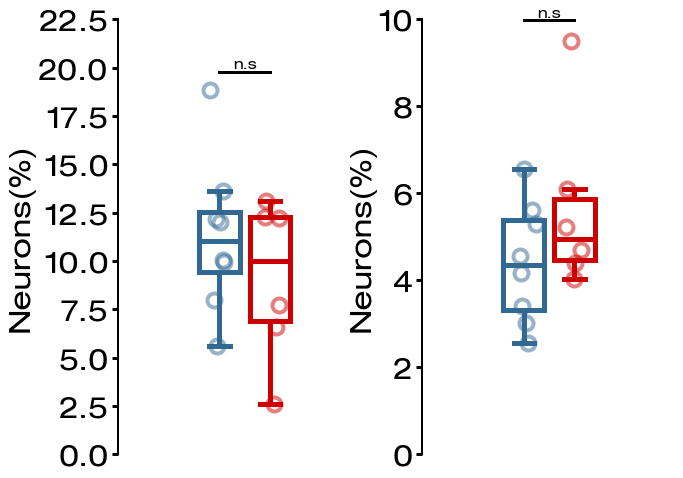

In [22]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():

    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=0]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=0]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
axs[0].set

Percentage of exc neurons activated (1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9491478800773621, pvalue=0.7026362419128418)
ShapiroResult(statistic=0.8846789002418518, pvalue=0.2912391722202301)
Ttest_indResult(statistic=0.7060241940036075, pvalue=0.49365281970484665)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9665555357933044, pvalue=0.8696940541267395)
ShapiroResult(statistic=0.7537350058555603, pvalue=0.021664319559931755)
MannwhitneyuResult(statistic=17.0, pvalue=0.4135864135864136)


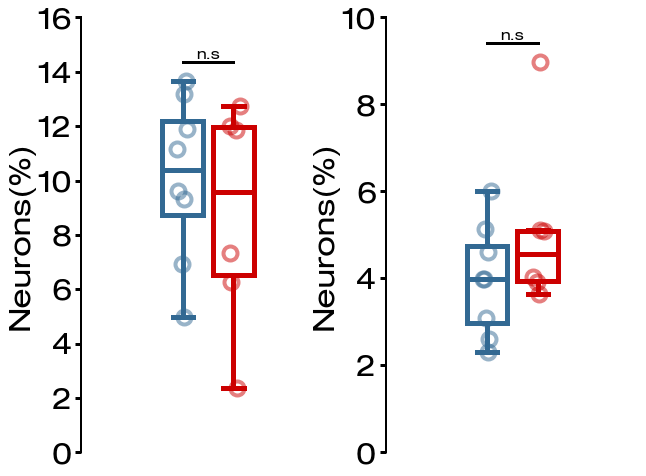

In [23]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=1]=0
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=1]=0
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of exc neurons inhibited (-1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.5582761168479919, pvalue=5.131508441991173e-05)
ShapiroResult(statistic=0.8713940382003784, pvalue=0.23181866109371185)
MannwhitneyuResult(statistic=44.0, pvalue=0.007992007992007992)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9693343639373779, pvalue=0.8927340507507324)
ShapiroResult(statistic=0.9714395403862, pvalue=0.9019615054130554)
Ttest_indResult(statistic=-0.7432421775386693, pvalue=0.4716363523099274)


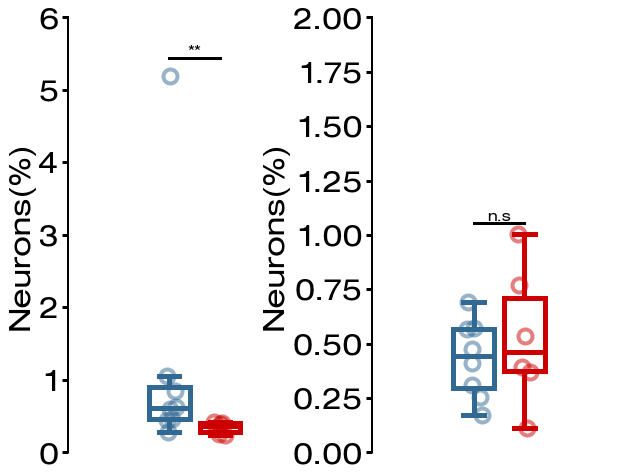

In [24]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['EXC']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=-1]=0
    trials_detected[trials_detected==-1]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=-1]=0
    trials_undetected[trials_undetected==-1]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

# INHIBITORY NEURONS

Percentage of inh neurons recruited (1 and -1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7993506789207458, pvalue=0.02817097306251526)
ShapiroResult(statistic=0.9275253415107727, pvalue=0.5611317753791809)
MannwhitneyuResult(statistic=34.0, pvalue=0.22843822843822847)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8249990940093994, pvalue=0.05264957621693611)
ShapiroResult(statistic=0.9391723275184631, pvalue=0.6525372862815857)
Ttest_indResult(statistic=-0.24498633887437687, pvalue=0.8106062960918792)


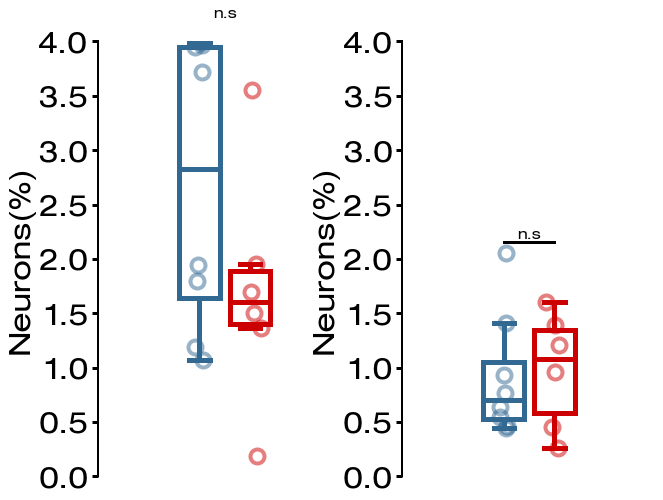

In [25]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=0]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=0]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of inh neurons activated (1) during stimulus detected and undetected


Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7771985530853271, pvalue=0.016239823773503304)
ShapiroResult(statistic=0.9439765214920044, pvalue=0.6913742423057556)
MannwhitneyuResult(statistic=29.0, pvalue=0.5727605727605728)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8036408424377441, pvalue=0.031308840960264206)
ShapiroResult(statistic=0.9892397522926331, pvalue=0.9872389435768127)
MannwhitneyuResult(statistic=25.0, pvalue=0.9497169497169498)


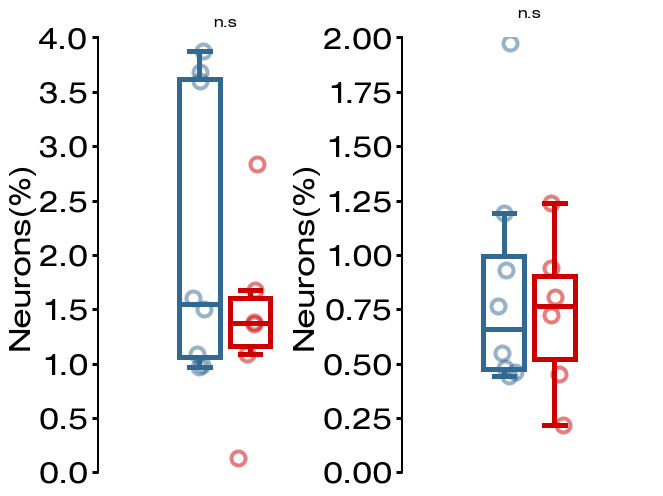

In [26]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=1]=0
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=1]=0
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

Percentage of inh neurons inhibited (-1) during stimulus detected and undetected

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.6356296539306641, pvalue=0.000413018831750378)
ShapiroResult(statistic=0.8828460574150085, pvalue=0.2823832631111145)
MannwhitneyuResult(statistic=28.0, pvalue=0.662004662004662)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7238142490386963, pvalue=0.004175425972789526)
ShapiroResult(statistic=0.7583016157150269, pvalue=0.02398942969739437)
MannwhitneyuResult(statistic=12.5, pvalue=0.13938620946554664)


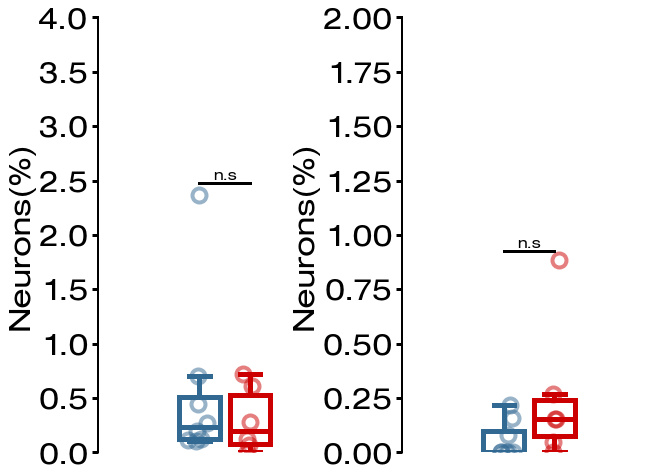

In [27]:
wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
for rec in recs.values():
    resp_mat = np.array(rec.matrices['INH']["Responsivity"])
    #detected
    trials_detected = resp_mat[:,rec.detected_stim]
    trials_detected[trials_detected!=-1]=0
    trials_detected[trials_detected==-1]=1
    recruited_det = np.sum(trials_detected,axis=0)
    perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
    #undetected
    trials_undetected = resp_mat[:,~rec.detected_stim]
    trials_undetected[trials_undetected!=-1]=0
    trials_undetected[trials_undetected==-1]=1
    recruited_undet = np.sum(trials_undetected,axis=0)
    perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
    if rec.genotype == "WT":
        wt_det.append(perc_n_det)
        wt_undet.append(perc_n_undet )
    else:
        ko_det.append(perc_n_det)
        ko_undet.append(perc_n_undet)
fig, axs = plt.subplots(1,2,figsize=(10,8))
ppt.boxplot(axs[0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1], wt_undet,ko_undet,"Neurons(%)",ylim=[])

#Comparison between WT vs KO-HYpo for recruited (+1 and -1) neurons


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=0]=1
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=1]=0
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,20])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,20])
    from matplotlib.ticker import MaxNLocator
    axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9599763751029968, pvalue=0.8098748326301575)
ShapiroResult(statistic=0.862433910369873, pvalue=0.2690175771713257)
Ttest_indResult(statistic=1.1081824140474592, pvalue=0.29372437500204795)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.9665555357933044, pvalue=0.8696940541267395)
ShapiroResult(statistic=0.6869834065437317, pvalue=0.008105842396616936)
MannwhitneyuResult(statistic=13.0, pvalue=0.6828282828282828)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.7993506789207458, pvalue=0.02817097306251526)
ShapiroResult(statistic=0.9558010697364807, pvalue=0.7524889707565308)
MannwhitneyuResult(statistic=24.0, pvalue=0.21414141414141416)
Boxplot plotting.
Neurons(%)
ShapiroResult(statistic=0.8036408424377441, pvalue=0.031308840960264206)
ShapiroResult(statistic=0.9495193362236023, pvalue=0.7131152749061584)
MannwhitneyuResult(statistic=14.0, pvalue=0.8080808080808081)


#Comparison between WT vs KO-HYpo for activated (+1) neurons


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=1]=0

        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=1]=0
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,20])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,20])
    from matplotlib.ticker import MaxNLocator
    axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

#Comparison between WT vs KO-HYpo for inhibited (-1) neurons

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_detected[trials_detected!=-1]=0
        trials_detected[trials_detected==-1]=1
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim]
        trials_undetected[trials_undetected!=-1]=0
        trials_undetected[trials_undetected==-1]=1
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,6])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,6])


Neurons inhibited for amp10

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,(rec.stim_ampl==6)]

        trials_detected[trials_detected!=1]=0

        recruited_det = np.sum(trials_detected,axis=0)
        print(np.mean(recruited_det))
        print(trials_detected.shape)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,(rec.stim_ampl==6)]
        trials_undetected[trials_undetected!=1]=0
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,20])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,20])
    axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

Comparaison of neurons activated between detected and undected for all stimulus


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,(rec.detected_stim) ]
        # trials_detected = trials_detected[~np.isnan(trials_detected)
        # if len(trials_detected)==0:
        #     continue
        trials_detected[trials_detected!=1]=0
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~(rec.detected_stim) ]
        trials_undetected[trials_undetected!=1]=0
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT" :
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)","WT",ylim=[0,18],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)","KO",ylim=[0,18])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for all stimulus")


Comparaison of neurons activated between detected and undected THRESHOLD stimulus

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,(rec.detected_stim) & (rec.stim_ampl==rec.threshold)]
        # trials_detected = trials_detected[~np.isnan(trials_detected)
        # if len(trials_detected)==0:
        #     continue
        trials_detected[trials_detected!=1]=0
        recruited_det = np.sum(trials_detected,axis=0)
        perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
        #undetected
        trials_undetected = resp_mat[:,~(rec.detected_stim) & (rec.stim_ampl==rec.threshold)]
        trials_undetected[trials_undetected!=1]=0
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/len(rec.zscore_exc))*100
        if rec.genotype == "WT" :
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)","WT",ylim=[0,18],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)","KO",ylim=[0,18])
    fig.suptitle("Comparaison of neurons activated between detected and undetected THRESHOLD stimulus")

# 22/03/2024  Threshold responsivity analysis

## Graph of activated neurons from amplitude

In [ ]:
import scipy.stats as ss
figs, axs = plt.subplots(2,1,figsize=(8,8))

amps=[2,4,6,8,10,12]
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        resp_p=[]
        for amp in amps:
            trials_detected = resp_mat[:,rec.stim_ampl==amp]
            trials_detected[trials_detected!=1]=0
            recruited_det = np.sum(trials_detected,axis=0)
            perc_n_det = (np.mean(recruited_det)/len(rec.zscore_exc))*100
            resp_p.append(perc_n_det)
        if rec.genotype == "WT":
            wt.append(resp_p)
        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(resp_p)
        elif rec.genotype =="KO":
            ko.append(resp_p)
        

    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].set_ylabel("Neurons (%)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_xlim([0,14])
    axs[i].set_ylim([0,15])
    axs[i].set_title(type)

axs[0].get_xaxis().set_visible(False)



## Graph of amplitude response from each stimulus amplitude


In [ ]:
import scipy.stats as ss
figs, axs = plt.subplots(2,1,figsize=(8,8))

amps=[2,4,6,8,10,12]
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)
        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15)
    axs[i].set_ylabel("Response amp (z-score)")
    axs[i].set_xlabel("Stimulus amplitude")
    axs[i].set_xlim([0,14])
    axs[i].set_ylim([0,5])
    axs[i].set_title(type)

axs[0].get_xaxis().set_visible(False)

Number of active neurons and behavior psychometric curves comparison animal by animals

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=26)

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=26)

percentage of neurons recruited for UNDETECTED TRIALS

In [ ]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(35, 20))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=26)